In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks, savgol_filter


### Data Preprocessing

In [67]:
# Readin the data set kepping date as index
df=pd.read_csv('weighted_sum.csv')

# Make the 'date' column as index of the DataFrame
df.index = df["date"].values

df.index = pd.to_datetime(df.index)

df.drop(columns='date', inplace=True)

# Reindexing DataFrame with pd.date_range, ensure df spans a specified period, filling in any gaps with NaN values.
idx = pd.date_range('2019-10-24', '2023-12-06')

df = df.reindex(idx)

# filter out the specified data range contaning zero
df=df.drop(df.loc['2023-05-12':'2023-07-27'].index)

# Filter out the initial date range considering machine unstability
df=df.drop(df.loc['2019-10-24':'2020-01-31'].index)


rows_to_fill = np.where(df["weighted_sum"].isna())

for row in rows_to_fill:

    df.iloc[row] = df.iloc[row + 7]

# Replace negative values with zero in 'weighted_sum'
df['weighted_sum'] = df['weighted_sum'].clip(lower=0)

# replace 7 irregular data points with 8th highest value.
df[df['weighted_sum']>570]=570

print(df)
df.describe()

            weighted_sum
2020-02-01    239.210369
2020-02-02     28.280318
2020-02-03    199.366981
2020-02-04    423.067131
2020-02-05    409.692107
...                  ...
2023-12-02    114.049422
2023-12-03      0.000000
2023-12-04    226.893157
2023-12-05    390.659238
2023-12-06    425.322937

[1328 rows x 1 columns]


,weighted_sum
count,1328.000000
mean,294.511578
std,164.458734
min,0.000000
25%,149.168497
50%,356.291042
75%,428.762568
max,570.000000


## Test for stationarity

### 1. The Augmented Dickey-Fuller test
Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


In [26]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['weighted_sum'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')            
for key, value in result[4].items(): #  iterates over these critical values, result=4, contains critical values for different significance levels of the ADF test
 print('\t%s: %.3f' % (key, value))


ADF Statistic: -5.893339
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


The p-value obtained is less than the significance level of 0.05, and the ADF statistic value of -4.056003 is lower than any of the critical values. Clearly, the null hypothesis is rejected. So, the time series stationary.

Moreover, The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -4 is less than the value of -3.449 at 1% and also for others.

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure



### 1. Autocorrelation Function: 
The Autocorrelation Function (ACF) can be used to measure the correlation between a time series and its lagged values. It helps to understand if and how a time series is related to its past values.
 

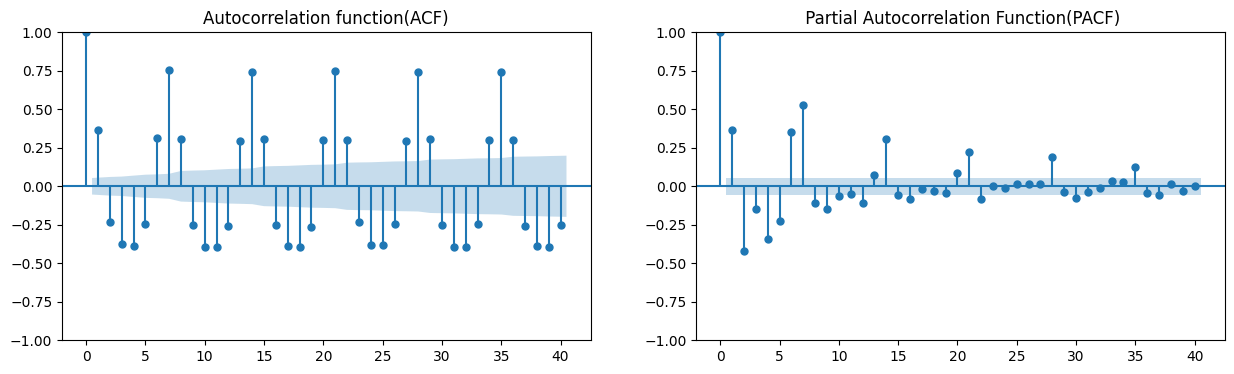

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

fig, axes= plt.subplots(1,2, figsize=(15,4))
plot_acf(df['weighted_sum'], lags=40, ax=axes[0], title='Autocorrelation function(ACF)')
plot_pacf(df['weighted_sum'], lags=40, ax=axes[1], title=' Partial Autocorrelation Function(PACF)')
plt.show()

The series can be considered stationary because it decays very quickly. This rapid decay indicates that the statistical properties of the series, such as the mean and variance, remain constant over time, suggesting stability and lack of long-term trends or cyclic patterns.

### 2. Summary Statistics:
A quick check whether time series is stationary or not by reviewing summary statistics i.e
simply split time series into two (or more) partitions and compare the mean and variance of each group. If they differ and the difference is statistically significant, the time series is likely non-stationary.

In [34]:
# Calculate the size of each partition
split1 = round(len(df) / 3)
split2 = round(2 * len(df) / 3)

# Split the DataFrame into three partitions using iloc
df1 = df.iloc[:split1]

df2 = df.iloc[split1:split2]

df3 = df.iloc[split2:]


# Calculate the means and variances for each partition
mean1, mean2, mean3 = df1.mean(), df2.mean(), df3.mean()
var1, var2, var3 = df1.var(), df2.var(), df3.var()

# Print the means and variances
print()
print('mean1=%f, mean2=%f, mean3=%f' % (mean1, mean2, mean3))

print()
print('variance1=%f, variance2=%f, variance3=%f' % (var1, var2, var3))
print()


mean1=301.858251, mean2=302.986129, mean3=278.709483

variance1=25936.492185, variance2=27570.254095, variance3=27380.662485



/var/folders/lb/4_gb1t5n2n12h48x7bbgkn3m0000gn/T/ipykernel_99058/3440897241.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('mean1=%f, mean2=%f, mean3=%f' % (mean1, mean2, mean3))
/var/folders/lb/4_gb1t5n2n12h48x7bbgkn3m0000gn/T/ipykernel_99058/3440897241.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('variance1=%f, variance2=%f, variance3=%f' % (var1, var2, var3))


### Seasonal Decompostion plot

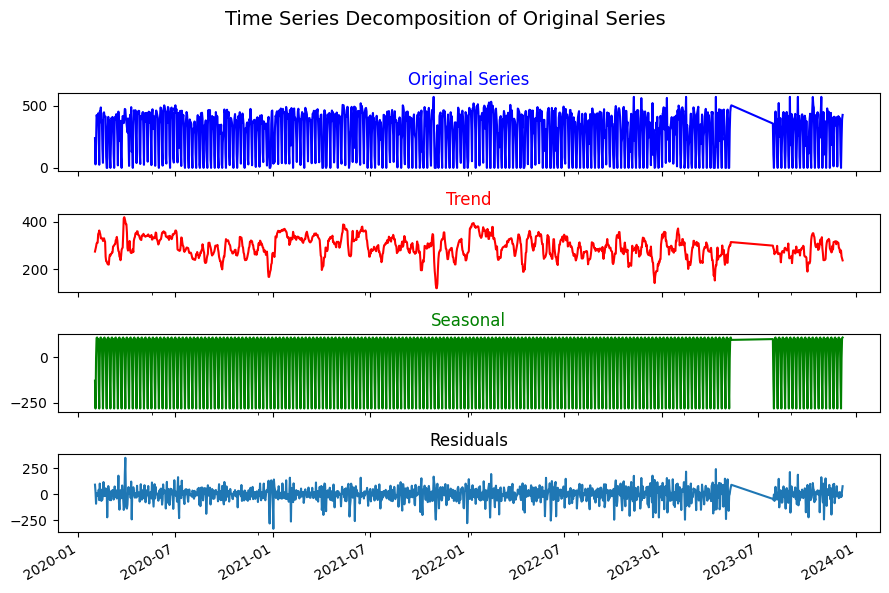

In [37]:


# Decompose with a period of 7
res_decompose = seasonal_decompose(df['weighted_sum'], model='additive', period=7, extrapolate_trend='freq')

# Create subplots
fig, axs = plt.subplots(nrows=4, figsize=(9, 6), sharex=True)

# Plot each component
res_decompose.observed.plot(ax=axs[0], color='blue')
axs[0].set_title('Original Series', fontsize=12, color='blue')

res_decompose.trend.plot(ax=axs[1], color='red')
axs[1].set_title('Trend', fontsize=12, color='red')

res_decompose.seasonal.plot(ax=axs[2], color='green')
axs[2].set_title('Seasonal', fontsize=12, color='green')

res_decompose.resid.plot(ax=axs[3])
axs[3].set_title('Residuals', fontsize=12)

# Set overall title and layout
fig.suptitle('Time Series Decomposition of Original Series', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid overlap with the main title
plt.savefig('decompose')

plt.show()


### Cross Validation (Train-Validation-test set)

In [75]:
# Define the train-test split parameters (70:30)
initial_train_size = int(0.7 * len(df)) # Start with 70% training data
initial_train_data= df[:initial_train_size]
initial_test_data=df[initial_train_size:]


# Now, split the initial training data into 70% training and 30% validation
train_size = int(0.7 * len(initial_train_data))
train_data=initial_train_data[:train_size]
test_data = initial_train_data[train_size:]
print(initial_train_data, initial_test_data , train_data ,test_data)

     weighted_sum
0      239.210369
1       28.280318
2      199.366981
3      423.067131
4      409.692107
..            ...
924    114.743957
925      0.000000
926    273.145554
927    382.488038
928    276.267078

[929 rows x 1 columns]       weighted_sum
929     193.901423
930     432.053452
931     134.239967
932       0.000000
933     293.099946
...            ...
1323    114.049422
1324      0.000000
1325    226.893157
1326    390.659238
1327    425.322937

[399 rows x 1 columns]      weighted_sum
0      239.210369
1       28.280318
2      199.366981
3      423.067131
4      409.692107
..            ...
645      0.000000
646    128.806820
647    416.624904
648    436.489289
649    444.859699

[650 rows x 1 columns]      weighted_sum
650    393.986012
651    134.879826
652      0.000000
653    390.718951
654    460.146419
..            ...
924    114.743957
925      0.000000
926    273.145554
927    382.488038
928    276.267078

[279 rows x 1 columns]


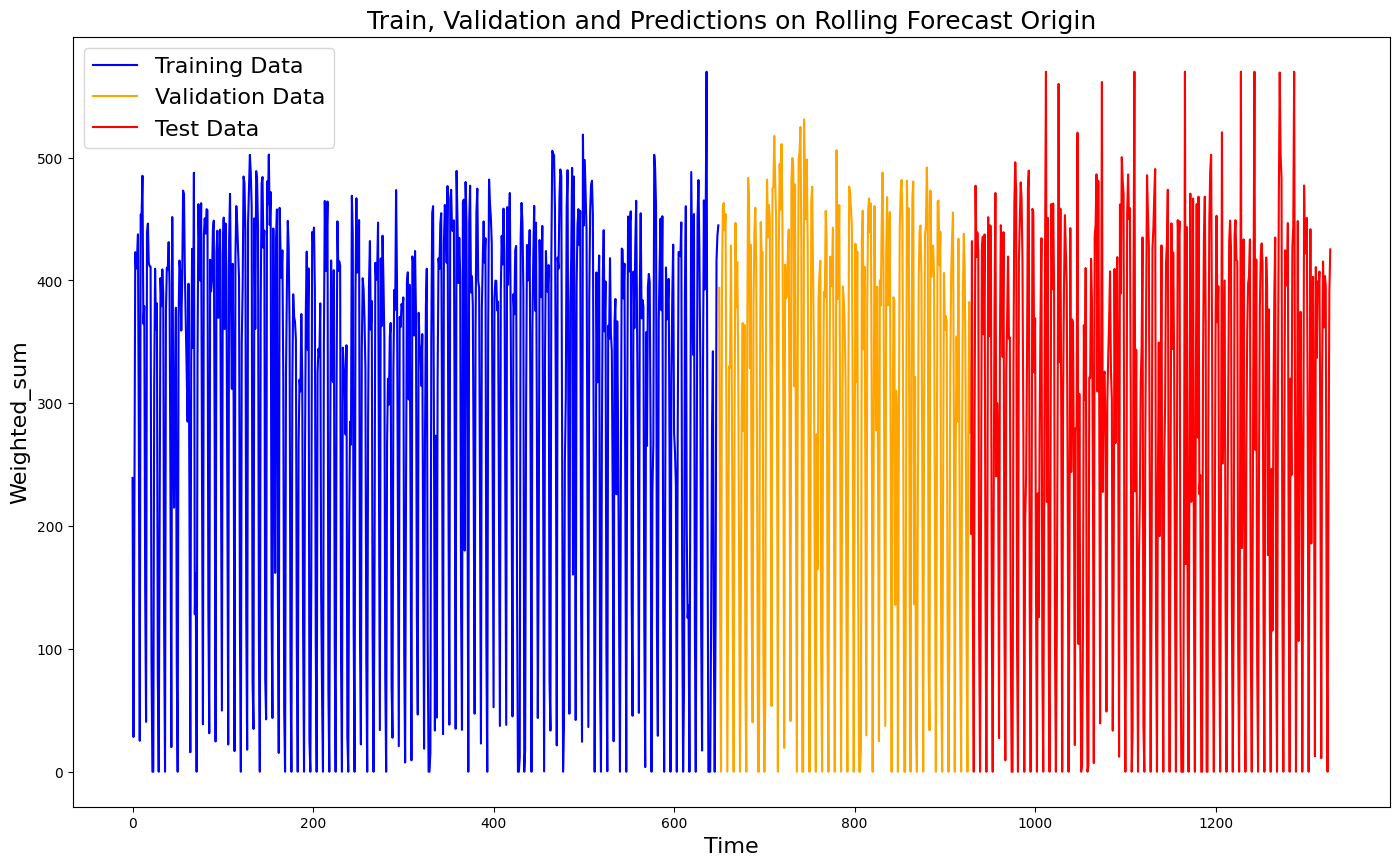

In [77]:
df.index = range(len(df))
# Plotting
fig, ax = plt.subplots(figsize=(17, 10))

# Plot train data
train_data['weighted_sum'].plot(ax=ax, label='Training Data', color='blue')

# Plot validation data
test_data['weighted_sum'].plot(ax=ax, label='Validation Data', color='orange')

# Plot test data
initial_test_data['weighted_sum'].plot(ax=ax, label='Test Data', color='red')


# Customize plot
ax.set_title('Train, Validation and Predictions on Rolling Forecast Origin', fontsize=18)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Weighted_sum', fontsize=16)
ax.legend(fontsize=16)
plt.savefig('train-test')

plt.show()


### Cross validation (Evaluation on rolling forecast origin)

Number of fold: 399.0

Initial train size: 929, Number of splits: 399


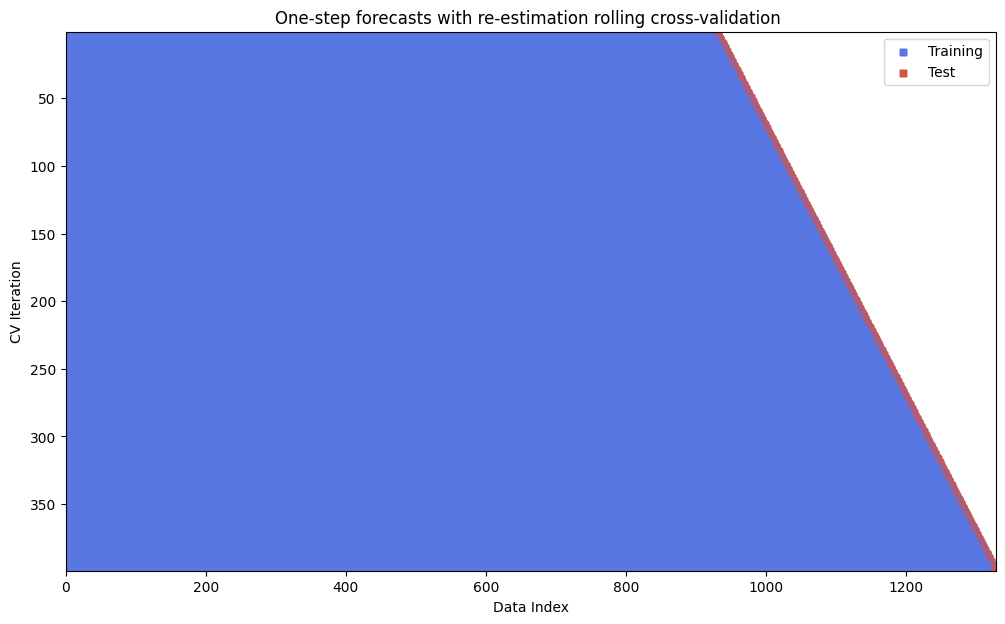

In [60]:
df.index = range(len(df))

# Define the train-test split parameters
initial_train_size = int(0.7 * len(df))  # Start with 70% training data
n_splits = len(df) - initial_train_size  # Remaining data for testing
test_size = 1  # Fixed test set size for each fold

n_folds= n_splits/test_size
print(f'Number of fold: {n_folds}')
print()

print(f"Initial train size: {initial_train_size}, Number of splits: {n_splits}")

# Visualization setup
fig, ax = plt.subplots(figsize=(12, 7))

# Iterate through the rolling cross-validation process
for i in range(0, n_splits, test_size):
    
    # Define the end points for the current fold
    train_end = initial_train_size + i
    test_end = min(train_end + test_size, len(df))  # Ensure not to exceed data length

    # Define the current training and test data for this split
    train_data = df.iloc[:train_end]
    test_data = df.iloc[train_end:test_end]

    #print(f"Train data from 0 to {train_end}, Test data from {train_end} to {test_end}")

    # Plot the training data
    l1 = ax.scatter(train_data.index, [i + 1] * len(train_data), c=[plt.cm.coolwarm(0.1)], 
                    marker='+', lw=5)
    
    # Plot the actual test data
    l2 = ax.scatter(test_data.index, [i + 1] * len(test_data), c=[plt.cm.coolwarm(0.9)], 
                    marker='+', lw=5)

# Set axis limits and labels
ax.set(ylim=[n_splits + 0.3, 0.7], xlim=[0, len(df)], title='One-step forecasts with re-estimation rolling cross-validation ',  xlabel='Data Index', ylabel='CV Iteration')

# Add a legend to the plot
ax.legend([l1, l2], ['Training', 'Test'])
plt.savefig('cross validation')

# Show the plot
plt.show()

### Construction of the frequency spectrum from the time-domain
The frequency spectrum can be used to determine whether the time-series contains any seasonal components, at which frequencies these seasonal components occur and how we can separate them.

A time-series can have multiple seasonal components (with different frequencies, amplitudes, etc) and mixed together in the total signal.


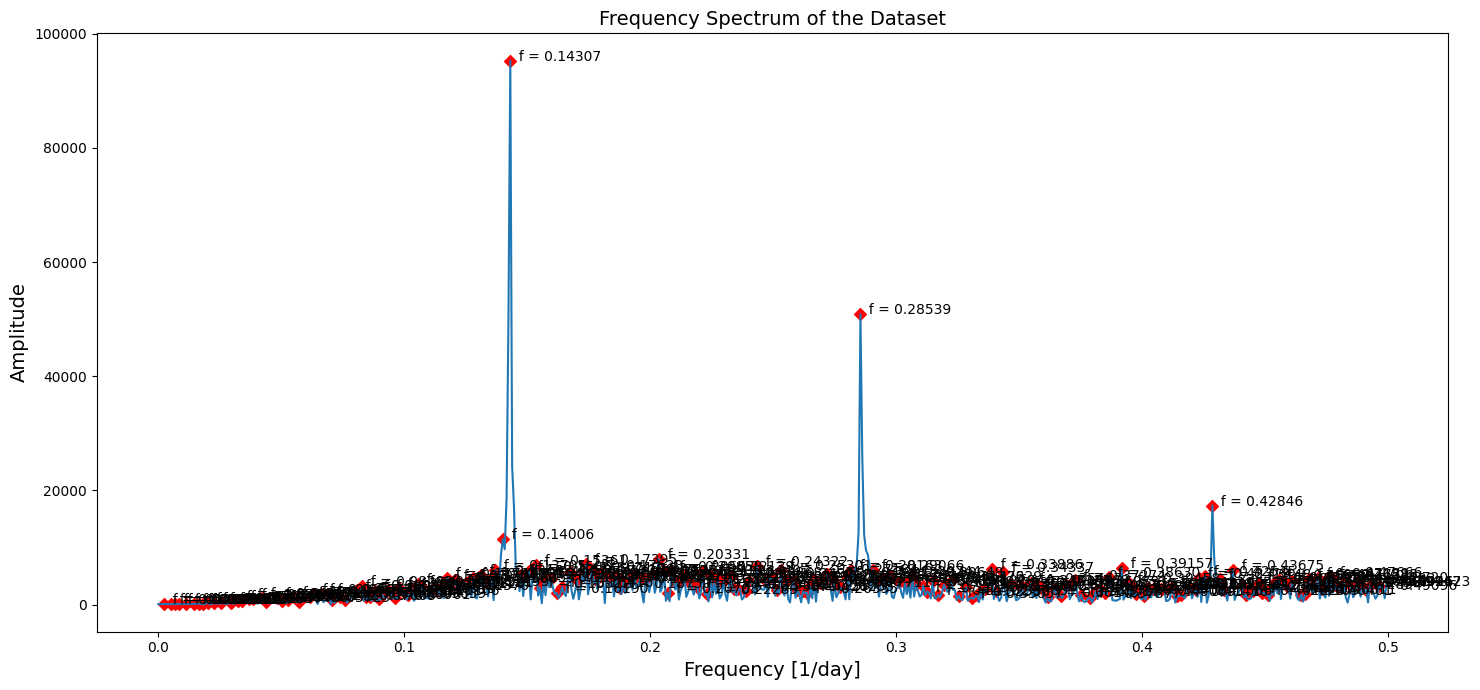

In [48]:
# Extract y-values from the DataFrame
yvalues = df['weighted_sum'].values

# Detrend or subtract the average value from data using Savitzky-Golay filter in order to remove the large peak at zero frequency.
yvalues_trend = savgol_filter(yvalues, window_length=7, polyorder=1) # smoothed yvalues, representing the trend component of data.
yvalues_detrended = yvalues - yvalues_trend # detrended original data, linear trend removed,


fft_y_ = np.fft.fft(yvalues_detrended) # Perform FFT on the detrended data. take absolute to make neg. amplitude positive and
fft_y = np.abs(fft_y_[:len(fft_y_) // 2]) # take into account the first half of frequency spectrum as second half is mirror image.(euler's formula)

fft_x_ = np.fft.fftfreq(len(yvalues_detrended)) # returns an array of frequency values corresponding to the FFT output
fft_x = fft_x_[:len(fft_x_) // 2]

# Detect peaks in the FFT magnitudes
indices_peaks, _ = find_peaks(fft_y)

# Plot the magnitude of FFT results and detected peaks
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(fft_x, fft_y)
ax.scatter(fft_x[indices_peaks], fft_y[indices_peaks], color='red', marker='D')
ax.set_title('Frequency Spectrum of the Dataset', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)
ax.set_xlabel('Frequency [1/day]', fontsize=14)

for idx in indices_peaks:
    x, y = fft_x[idx], fft_y[idx]
    text = "  f = {:.5f}".format(x, y)
    ax.annotate(text, (x, y))

plt.tight_layout()
plt.savefig('frequency')
plt.show()

here, we can see the absolute, positive frequency values of the detrended time-series.
This frequency spectrum looks much better and more like a frequency spectrum we are used to. There are several peaks in the frequency spectrum at f = 0.14307, 0.28539, and 0.42846. These frequencies correspond with a period ( T = 1 / f) of 6.99, 3.5, and 2.33 days. Meaning there is a seasonal components which occurs every week, half of a week.